<h1><center>Segmentacion de imagenes: Metodo de conjunto de nivel</center></h1>
<center><strong>Análisis Numérico de Ecuaciones en Derivadas Parciales:Teoría y Laboratorio</strong></center>
<center>Autores: Felipe Urrutia, Daniel Minaya, Sebastian Toloza</center>
<center>Tutor: Axel Osses A., Auxiliar: Emir N. Chacra</center>

# Primeros resultados

Estudio del conjunto de imagenes de los Problemas de Bongard

In [1]:
from class_levelsetmethod import LevelSetMethod, Image, np, plt, animation

Wall time: 32 ms


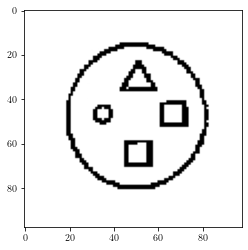

In [2]:
%%time
id_name="BP071_10"
img_o = Image.open(f"dataset/dataset_bp/{id_name}.jpg")

dim = (img_o.size[1], img_o.size[0])
img = np.array(img_o.getdata()).reshape((dim[0], dim[1]))

plt.imshow(img, cmap="gray");

<set_image> img: <class 'numpy.ndarray'>, reshape: True, norm: True
|img_dim:     [98 98]
|img_min/max: (0, 255)
|new_img_min/max(norm): (0, 255)
|size_domain: 9604
</set_image>
Wall time: 24 ms


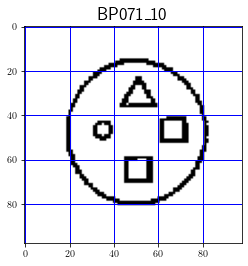

In [3]:
%%time
segmentator = LevelSetMethod(id_name="BP071_10")
segmentator.set_image(
    img, 
    reshape=True,
    norm=True
)
segmentator.show_image(grid=True)

Wall time: 312 ms


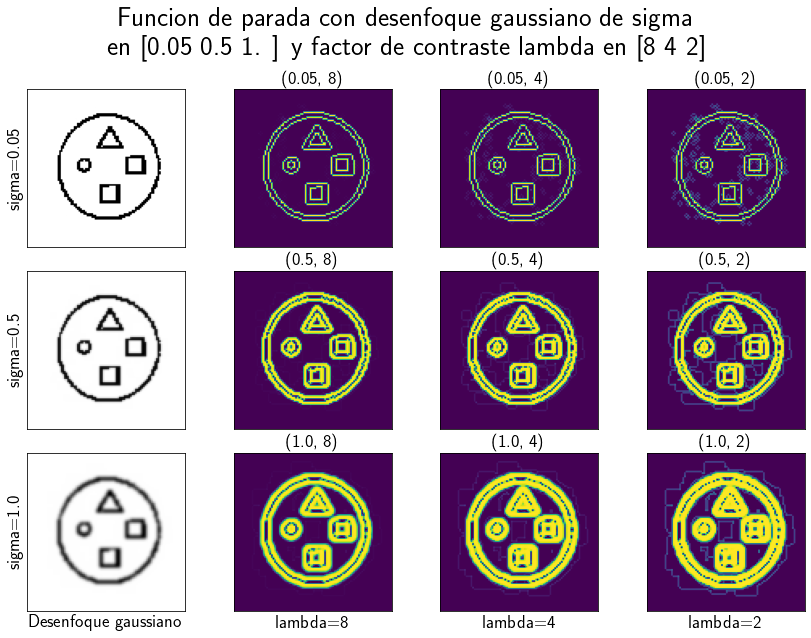

In [4]:
%%time
segmentator.eval_stopfunct(
    list_sgm=np.array([0.05, 0.5, 1]), 
    list_lmbd=np.array([8, 4, 2]),
    cmap="viridis_r"
)

In [5]:
%%time
segmentator.set_stopfunct(
    sgm=0.05, 
    lmbd=8,
)

<set_stopfunct> sigma: 0.05, lambda: 8
|gauss_min/max: (0, 255)
|stopfunct_min/max:     (0.00024599867775710704, 1.0)
</set_stopfunct>
Wall time: 0 ns


Wall time: 32 ms


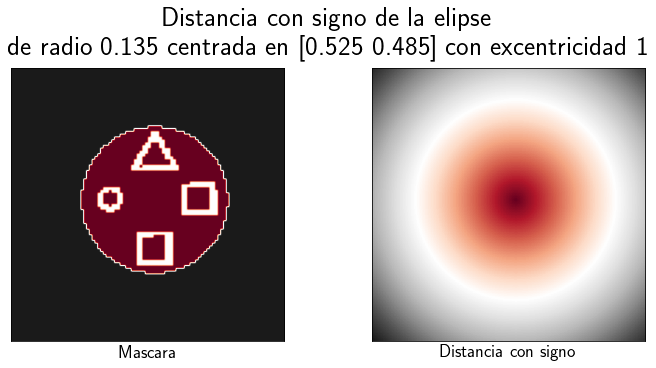

In [6]:
%%time
segmentator.eval_sgndist(
    c=np.array([0.525, 0.485]), 
    r=0.135,
    e=1
)

In [7]:
%%time
segmentator.set_sgndist(
    c=np.array([0.525, 0.485]), 
    r=0.135,
    e=1
)

<set_sgndist> centro: [0.525 0.485], radio: 0.135, excentricidad: 1
</set_sgndist>
Wall time: 4.01 ms


Wall time: 71.9 ms


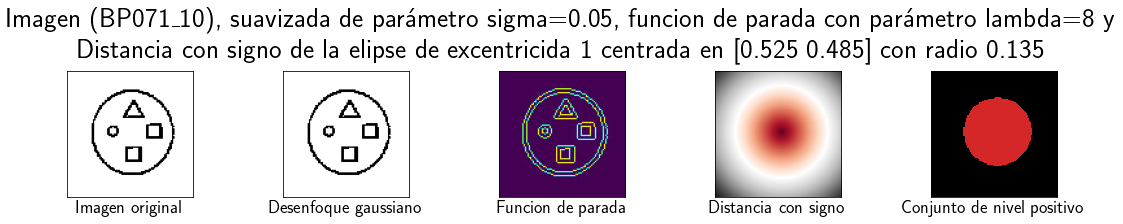

In [8]:
%%time 
segmentator.show_setting(cmap_stopfunct="viridis_r")

In [9]:
%%time 
segmentator.print_setting()

<print_setting>
|sigma: 0.05
|lambda: 8
|centro: [0.525 0.485]
|radio: 0.135
|excentricidad: 1
</print_setting>
Wall time: 0 ns


In [10]:
%%time
segmentator.solve(
    n_iter = 200,
    tau = 0.25,
    k = -2,
    save_rate=10,
    root_path_save="results",
    show_log_rate=5
)

<solve> N° iteraciones: 200, discretizacion en tiempo: 0.25, constante k: -2
|path_save_file: results/BP071_10__iterations_times__sgm_0_05__lmbd_8__cx_0_525__cy_0_485__r_0_135__e_1__tau_0_25__k_-2
|Iter: 1, T iter: 3.4s, T trans:  6.9s, T per iter: 3.5s p/m  0.0s, T rest:  690.2s p/m  0.6s
|Iter: 6, T iter: 4.3s, T trans:  25.3s, T per iter: 3.6s p/m  0.3s, T rest:  704.9s p/m  3.9s
|Iter: 11, T iter: 3.4s, T trans:  44.3s, T per iter: 3.7s p/m  0.3s, T rest:  701.4s p/m  3.8s
|Iter: 16, T iter: 3.5s, T trans:  61.2s, T per iter: 3.6s p/m  0.3s, T rest:  666.2s p/m  3.8s
|Iter: 21, T iter: 3.6s, T trans:  79.6s, T per iter: 3.6s p/m  0.3s, T rest:  651.4s p/m  3.4s
|Iter: 26, T iter: 3.3s, T trans:  97.3s, T per iter: 3.6s p/m  0.2s, T rest:  630.4s p/m  3.2s
|Iter: 31, T iter: 3.5s, T trans:  114.3s, T per iter: 3.6s p/m  0.2s, T rest:  607.0s p/m  3.1s
|Iter: 36, T iter: 3.4s, T trans:  133.0s, T per iter: 3.6s p/m  0.2s, T rest:  593.3s p/m  3.1s
|Iter: 41, T iter: 3.5s, T trans:  1

Wall time: 184 ms


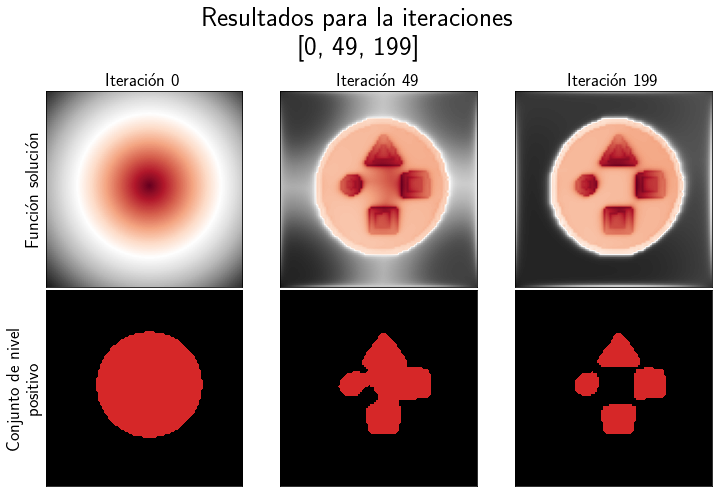

In [11]:
%%time
segmentator.show_solution(
    show_iters=[0, 49, 199]
)

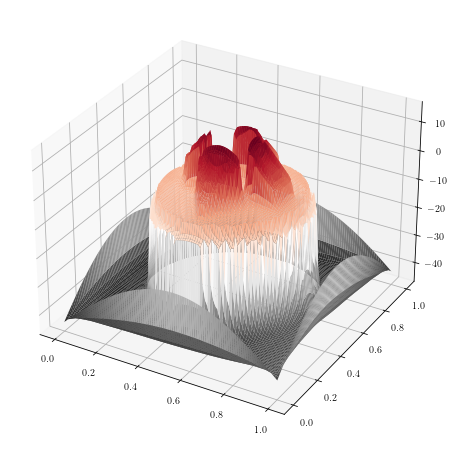

In [12]:
fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(111, projection='3d')
x = np.linspace(0, 1, segmentator.dim[0])
y = np.linspace(0, 1, segmentator.dim[1])
xx, yy = np.meshgrid(x, y)
zz = segmentator.iterations[199]
z = np.ravel(zz)
# ax.scatter(xx, yy, z, c=z, cmap='viridis', linewidth=0.5);
# ax.plot_trisurf(np.ravel(xx), np.ravel(yy), z, cmap='RdGy_r', linewidth=1);
ax.plot_surface(xx, yy, zz, rstride=1, cstride=1, 
                cmap='RdGy_r', edgecolor='none');

MovieWriter ffmpeg unavailable; using Pillow instead.


Wall time: 2min 49s


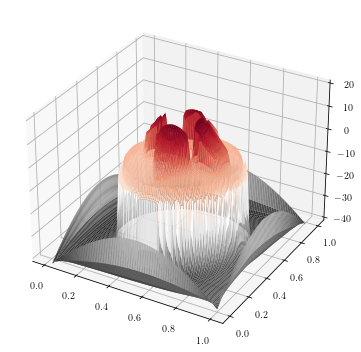

In [13]:
%%time
fps = 250
frn = 200

x = np.linspace(0, 1, segmentator.dim[0])
y = np.linspace(0, 1, segmentator.dim[1])
xx, yy = np.meshgrid(x, y)

zarray = np.zeros((segmentator.dim[0], segmentator.dim[1], frn))

for i in range(frn):
    zarray[:, :, i] = segmentator.iterations[i]

def change_plot(frame_number, zarray, plot):
    plot[0].remove()
    plot[0] = ax.plot_surface(xx, yy, zarray[:, :, frame_number], rstride=1, cstride=1, 
                cmap='RdGy_r', edgecolor='none')

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')

plot = [ax.plot_surface(xx, yy, zarray[:, :, 0], rstride=1, cstride=1, 
                cmap='RdGy_r', edgecolor='none')]
plt.tight_layout()
ax.set_zlim(-40, 20)
ani = animation.FuncAnimation(fig, change_plot, frn, fargs=(zarray, plot), interval=1000 / fps)

# ax.axis('off')

ani.save('matplot003.gif');

<img src="matplot003.gif">